# Multiple plotting of modules parameters, acquired by the flash test technique, after different treatments

### Introduction
This programm plots the module parameters versus the irradiance for various module treatment. The parameters are acquired using the flash test method.
<br/>
The module parameters, as well as the I/V curves, are stored in .csv files which names obeys the following format:
- UUUdddd_ddddW_Td.csv with U=[A-Z,-,_] and d=[1-9]. We have:
  - UUUdddd_dddd is the module type. The number of U is unlimited  and the  the number of digits d is limited to 50
  - ddddW is the irradiande in W/m^2. The number of digits d cannot be greater than 4.
  - Td is the treatment label. The numer of digit d is equal to 1.
  
These files are stored in the *data_folder* and all its sub folders. By default *data_folder* is set to *WORKING_DIR*= ~/PVcharacterization_files/flash test. This path is stored in the  configuration file *Pvcharacterization.yaml*. 

The structure of the WORKING_DIR must obeys the following structure:
<pre>WORKING_DIR
├── exp_summary.xlsx
├── pv.db
├── BOREALIS
│   ├── LC-BOREALIS-03_0200W_T0.csv
│   ├── LC-BOREALIS-03_0200W_T1.csv
│   └── ...
├── IVcurves
│   ├── EM7621190702200776_1000W_T0.csv
│   ├── EM7621190702200776_1000W_T3.csv
│   └── ...
├── JINERGY
│   ├── JInergy035
│   │   ├── JINERGY3272023326035_0200W_T0.csv
│   │   ├── JINERGY3272023326035_0200W_T1.csv
│   │   └── ....
│   ├── JInergy060
│   │   ├── JINERGY3272023326060_0200W_T0.csv
│   │   ├── JINERGY3272023326060_0200W_T1.csv
│   │   └──...
│   └── JInergy063
│       ├── JINERGY3272023326063_0200W_T0.csv
│       ├── JINERGY3272023326063_0200W_T1.csv
│       └── ...</pre> 
Where *pb.db* is a sqlite database containing two tables.


### Description
</br></br>
The program:
1. Interactevelly defines the *data_folder* where *data_folder* must be locate is the users home directory.
2. Recursivelly builds the list of all .csv file located in the folder *data_folder* and its sub-folders.
3. Interactivelly selects the list modules to be analysed and build the dataframe *df_meta* containing all the data necessary to the plotting of the modules parameters
4. Interactivelly defines the list of tuple [(T(i),T(j))], where T(i) stands for the ieme treatment.
5. Interactivelly convert the symbolic items T(i) into the name of the treatment.
6. For *n_params* parameters interactivelly sectected plots the *n_params* the parameters relative variation between two treatments T(k) and T(h):
    
   $$100\frac{{Para{m_i}(Irradiance(n);T(h),module(m)) - Para{m_i}(Irradiance(n);T(k),module(m))}}{{Para{m_i}(Irradiance(n);T(k),module(m))}}$$
   
### Module description
   
The program relies on the package *PVcharacterization_Utils* containig the following modules:
1. PVcharacterization_GUI 
    - input_treatment_labels
    - select_items
    - select_files
    - select_data_dir
2. PVcharacterization_flashtest 
    - assess_path_folders
    - batch_filename_correction
    - build_files_database
    - build_metadata_dataframe
    - build_modules_filenames
    - build_modules_list
    - correct_filename
    - data_dashboard
    - parse_filename
    - pv_flashtest_pca
    - read_flashtest_file
3. PVcharacterization_global 
    - DEFAULT_DIR (Path.home())
    - DATA_BASE_NAME
    - DATA_BASE_TABLE_FILE
    - DATA_BASE_TABLE_EXP
    - COL_NAMES
    - PARAM_UNIT_DIC
    - IRRADIANCE_DEFAULT_LIST
    - TREATMENT_DEFAULT_LIST
4. PVcharacterization_image (not used)
    - crop_image
    - py2gwyddion
    - read_electolum_file
5. PVcharacterization_plot
    - construct_x_y
    - init_plot_diff
    - plot_params 
    - plot_params_diff
    - plot_iv_power
6. PVcharacterization_database
    - add_files_to_database
    - sieve_files
    - suppress_duplicate_database
    - sqlite_to_dataframe
    - df2sqlite
    
### How use the package
1. Define you working directory name *data_folder*
2. Create/modify the sqlite database
3. Than you can:
   - Perform PCA analysis
   - I/V curves plotting
   - Parameters plotting
   - ...
   
### How modify the module setting
All the global are defined in the PVcharacterization.yaml file located in the package and are accessible from the dict *GLOBAL*.
    
### Nomenclature:
 - module-type (mod): ex. QCELL-2739, QCELLS901719162417702739
 - parameters (param): ex. Pmax, Voc, Isc, Fill Factor, Rseries
 - irradiance (irr): irradiance in W/m^2 
 - treatment (trt): treatment type T0, T1, T2,T2,...

In [17]:
''' 
    Creation: 2021.11.14
    Last update: 2021.11.20

    Choose the working directory

'''

# Local imports 
import PVcharacterization_Utils as pv

change_working_folder = input(f'Your working directory is {pv.GLOBAL["WORKING_DIR"]} do you want to change (y,n)?')
if change_working_folder=='y':
    data_folder = pv.assess_path_folders()
    pv.change_config_pvcharacterization(data_folder)
else:
    data_folder = pv.GLOBAL['WORKING_DIR']

Your working directory is C:\Users\franc\PVcharacterization_files\flash test do you want to change (y,n)?n


In [19]:
''' 
    Creation: 2021.09.13
    Last update: 2021.11.21

    User specific paths definition

'''

# Standard library imports
import os
from pathlib import Path

# Local imports 
import PVcharacterization_Utils as pv

if not(os.path.isfile(Path(data_folder) / Path(pv.GLOBAL['DATA_BASE_NAME']))):
    pv.build_files_database(data_folder)
    pv.build_metadata_dataframe(data_folder)
    print('builds the database {Path(data_folder) / Path(pv.DATA_BASE_NAME)}')
    
else:
    new_database = input(f'The database {pv.GLOBAL["DATA_BASE_NAME"]} already exits do you want to overwrite it (y,n)?')  
    if new_database == 'y':
        pv.build_files_database(data_folder)
        pv.build_metadata_dataframe(data_folder)
    else:
        add_to_database = input(f'Do you want to add file(s) to the database (y,n)?')  
        if add_to_database == 'y':
            pv.add_exp_to_database(data_folder)
        
# Correction of wrong filenames
filename_correct = 'n'
filenames_correct = input('Correction of filenames (y,n)?')
if filenames_correct=='y':
    verb = False
    status = pv.batch_filename_correction(data_folder, verbose=verb)
    print(status)

The database pv.db already exits do you want to overwrite it (y,n)?n
Do you want to add file(s) to the database (y,n)?y
the following 20 files has been added :
 C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_0600W_T0.csv
C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_0600W_T2.csv
C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_0200W_T3.csv
C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_0800W_T1.csv
C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_0400W_T0.csv
C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_1000W_T2.csv
C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_0200W_T1.csv
C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_0400W_T3.csv
C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_0600W_T3.csv
C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_0800W_T3.csv
C:/Users/franc/PVcharacterization_files/BOREALIS\LC-BOREALIS-03_0400W

In [2]:
''' Creation: 2021.10.17
    Last update: 2021.11.13
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    and PCA analysis
    
'''
# Local imports
import PVcharacterization_Utils as pv

df_meta = pv.build_metadata_df_from_db(data_folder)
print(df_meta.describe())
df_meta_pca = pv.pv_flashtest_pca(df_meta,scree_plot = False,interactive_plot=True)

             Pmax  Fill Factor         Voc         Isc     Rseries  \
count  282.000000   282.000000  282.000000  282.000000  282.000000   
mean   203.388438     0.785810   44.092559    5.895120    0.779906   
std     97.377562     0.021540    5.164885    2.827847    0.439028   
min     46.907900     0.674940   36.247500    1.543070    0.321700   
25%    124.723000     0.776423   39.760850    3.605420    0.484150   
50%    199.757000     0.787655   43.262800    5.593330    0.632625   
75%    295.987750     0.800118   49.351175    8.387135    0.955465   
max    376.158000     0.817790   53.415300   10.720600    2.458360   

            Rshunt         Vpm         Ipm    Isc_corr  Fill Factor_corr  \
count   282.000000  282.000000  282.000000  282.000000        282.000000   
mean    635.312839   36.845457    5.543708    5.889104          0.787114   
std     568.993420    4.176907    2.667204    2.822445          0.021832   
min       0.438790   31.046500    1.410720    1.534012          0

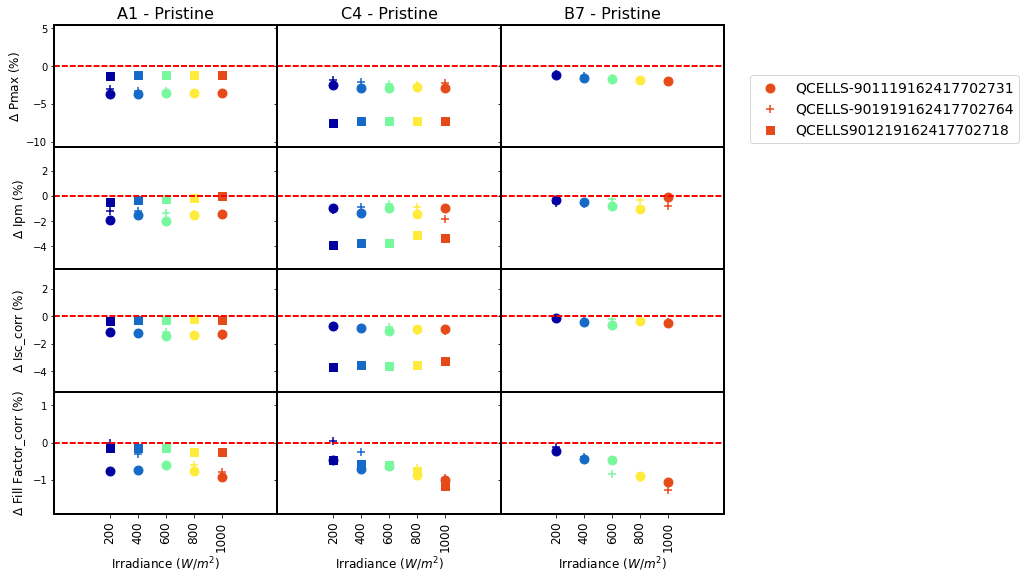

In [3]:
''' Creation: 2021.10.03
    Last update: 2021.11.13
    
    Interactive choice of the treatment differences
    
    ''' 
# Local imports
import PVcharacterization_Utils as pv

plot_param_dict = {'markers': ["o", "+", "s", "<", ">", "p", "1", "2", "3", "4"],
                     'marker_colors': ['#0000A0','#1569C7','#78f89d','#FFEB3B','#E64A19'],
                     'marker_size': 80,
                     'legend_fontsize': 14,
                     'ticks_fontsize': 12,
                     'labels_fontsize': 12,
                     'title_fontsize':16,
                     'fig_width': 12, 
                     'fig_height_unit': 2,
                     'fig_title_height': 1,
                     'bbox_x0': 0.25, 
                     'bbox_y0': 0.25, 
                     'bbox_width': 1, 
                     'bbox_height': 1,
                     'irr_add_nbr':0.5}

df_meta = pv.build_metadata_df_from_db(data_folder)
list_diff = pv.init_plot_diff(df_meta)
dic_trt_meaning = pv.input_treatment_labels(list_diff)
pv.plot_params_diff(df_meta,
                    list_diff,
                    None,
                    dic_trt_meaning,
                    long_label=False,
                    plot_params_dict=plot_param_dict)


In [4]:
''' Creation: 2021.09.19
    Last update: 2021.11.20
    
    Plotting of I/V curves.
    
    ''' 
# Local imports
import PVcharacterization_Utils as pv

df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.GLOBAL['DATA_BASE_TABLE_FILE'])
list_mod_selected = pv.build_modules_list(df_files_descp,data_folder)
irr_select = pv.GLOBAL['IRRADIANCE_DEFAULT_LIST']
trt_select = pv.GLOBAL['TREATMENT_DEFAULT_LIST']
pv.plot_iv_curves(irr_select,list_mod_selected,trt_select,data_folder)

In [5]:
''' Creation: 2021.10.20
    Last update: 2021.11.13
Build a dashboard

'''
# Local imports
import PVcharacterization_Utils as pv

#df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.DATA_BASE_TABLE_FILE)
list_params = ['Pmax']#,'Voc','Isc','Fill Factor','Rseries',]
df_meta_dashboard =  pv.data_dashboard(data_folder,list_params)
df_meta_dashboard

The file C:\Users\franc\PVcharacterization_files\flash test\exp_summary.xlsx has been created


Pmax                             \
irradiance                                200      400      600      800    
module_type                 treatment                                       
CHIC716                     T0         61.4897  126.150  190.470  254.022   
                            T1         61.1323  124.173  185.858  245.920   
                            T2         60.9575  123.593  184.677  244.293   
                            T3         61.2576  123.554  183.884  241.998   
CHIC717                     T0         60.8683  125.592  190.117  254.391   
...                                        ...      ...      ...      ...   
SERAPHIM-EM7621190702200654 T0         60.6749      NaN      NaN      NaN   
SERAPHIM-EM7621190702200656 T0         61.5945  127.388  194.021  260.536   
                            T1         60.2480  124.163  188.744  252.768   
                            T2         60.6445  124.935  189.672  253.705   
                            T3         60.7311  124.223  187.361  248.683   

                                                
irradiance                                1000  
module_type                 treatment           
CHIC716                     T0         316.354  
                            T1         303.600  
                            T2         301.059  
                            T3         297.689  
CHIC717                     T0         317.422  
...                                        ...  
SERAPHIM-EM7621190702200654 T0             NaN  
SERAPHIM-EM7621190702200656 T0         326.495  
                            T1         316.249  
                            T2         316.594  
                            T3         308.100  

[70 rows x 5 columns]

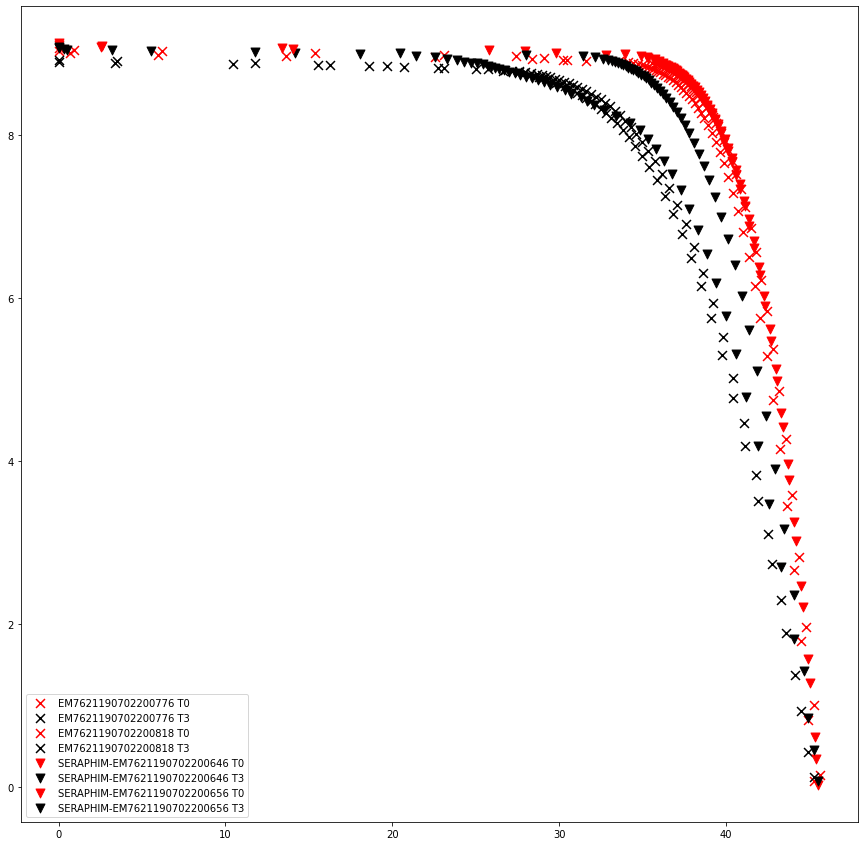

In [6]:
'''Creation: 2021.11.03
    Last update: 2021.11.04
Plot IV curves
'''
# 3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv

# Get dataframe describing the experimental files
df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.GLOBAL['DATA_BASE_TABLE_FILE'])   

# Select the module types which names has to be corrected
list_mod_selected = pv.build_modules_list(df_files_descp,data_folder)
iv_curve = {pv.parse_filename(file): pv.read_flashtest_file(file).IV0 
            for file in pv.build_modules_filenames(list_mod_selected,data_folder)}

colors = {'T0':'r','T3':'k'}
markers = {'EM7621190702200776':'x',
           'EM7621190702200818':'x',
           'SERAPHIM-EM7621190702200646':'v',
           'SERAPHIM-EM7621190702200656':'v'}
fig = plt.figure(figsize=(15,15))
for name,value in iv_curve.items():
    if name.treatment in ['T0','T3'] and name.irradiance==1000:
        plt.scatter(value["Voltage"][::70],
                    value["Current"][::70],
                    s=80,
                    label=f'{name.module_type} {name.treatment}',
                    c=colors[name.treatment],
                    marker=markers[name.module_type],
                    alpha=1)
    
_ = plt.legend()

Filename: C:\Users\franc\PVcharacterization_files\flash test\PCT\QCELLS-901919162417702764_1000W_T3.csv

PV characterization Data:
Pmax=332.06 W
Isc=10.96 A, Isc_corr=10.46 A
Voc=40.34 V
Fill Factor=0.751, corrected Fill Factor=0.787
Vpm=33.30 V
Ipm=9.97 V

Manufacturer data :
Pmax=331.94 W
Isc=10.72 A
Voc=40.34 V
Fill Factor=0.77 1
Vpm=33.29 V
Ipm=9.97 A


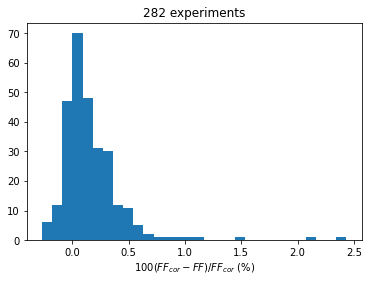

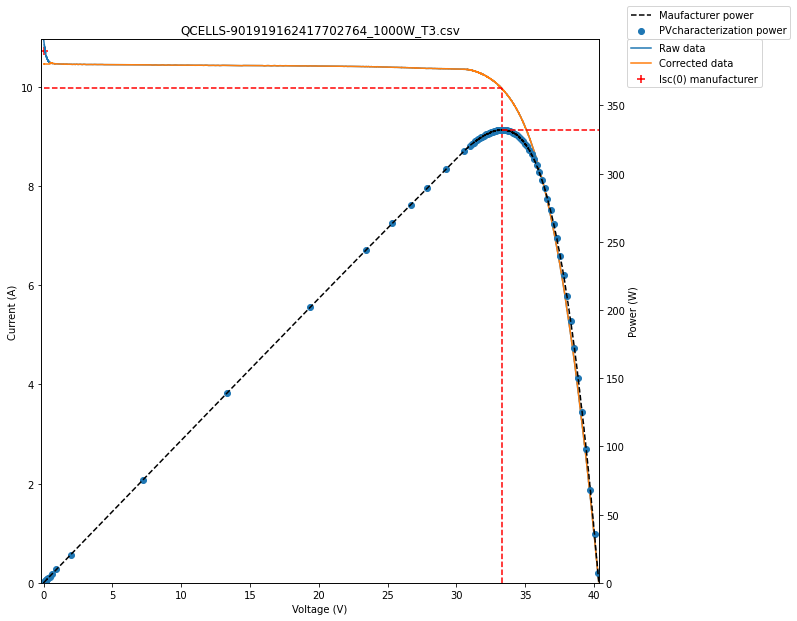

In [7]:
'''Creation: 2021.11.03
    Last update: 2021.11.21
Builds a dadaframe with ff,ff_cor,Isc,Isc_cor,100(ff_cor-ff)/ff_cor
Finds the maximum value of 100(ff_cor-ff)/ff_cor
Plots histogram and power I/V curves 
'''
# Standard library imports
from pathlib import Path

#3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv


df_meta = pv.build_metadata_df_from_db(data_folder,mode='all')
plt.title(f'{len(df_meta)} experiments')
df_meta['ecart_ff_pc'] = df_meta.apply(lambda x: 100*(x['Fill Factor_corr']-x['Fill Factor'])/x['Fill Factor_corr'],axis=1)
dg = df_meta.query('ecart_ff_pc>0.1')
_ = plt.hist(df_meta['ecart_ff_pc'],bins=30)
plt.xlabel('$100(FF_{cor} - FF)/FF_{cor}$ (%)')
idmax = df_meta['ecart_ff_pc'].idxmax(axis=0)

path_database = data_folder / Path(pv.GLOBAL['DATA_BASE_NAME'])
files = pv.sieve_files([df_meta.loc[idmax,'irradiance']],
                       [df_meta.loc[idmax,'treatment']],
                       [df_meta.loc[idmax,'module_type']],
                       path_database)

pv.plot_iv_power(files[0])

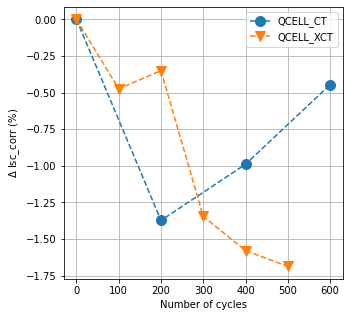

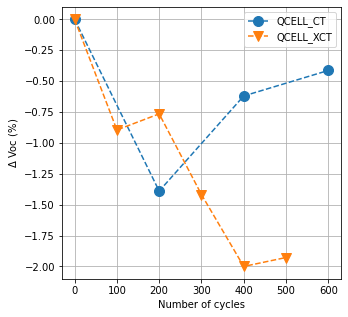

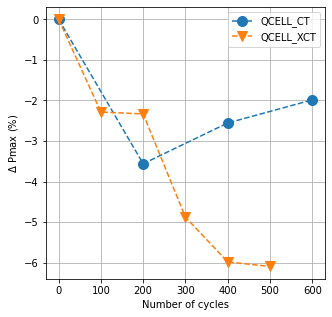

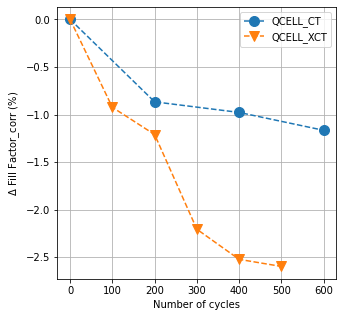

In [8]:
'''Creation: 2021.11.16
    Last update: 2021.11.18
Plot the mean retative parameters variation of two sets of experiments exp1 and exp2. 
'''


def compute_parameter_relative_diff(df_meta,irradiance, module_type_tag, parameter):
    
    '''Computes:
    100[parameter(TI;irradiance,module_type)-parameter(T0;irradiance,module_type)]/parameter(T0;irradiance,module_type)
    for all TI such that the string module_type_tag is part of the experiment name.
    
    Args:
      df_meta (dataframe): The columns contain the parameter values and the experimental conditions 
          and the row the experiment key.
      irradiance (int): The value of the irradiance used for the experiment.
      module_type_tag (str): A string contained in the module_type.
      parameter (str): The parameter of interest.
      
    Returns
      (namedtuple) a named tuple containing the list of treatments and the list of parameter 
      and a np.array of relative variations.
      
    '''
    
    # Standard library imports
    from collections import namedtuple


    param_diff = namedtuple(
        "param_diff",
        ["treatment", "delta_param"],
    )
    
    df_meta_m = df_meta[(df_meta['module_type'].str.contains(module_type_tag)) &
                        (df_meta['irradiance'] == irradiance)] 
    treatment = df_meta_m['treatment'].tolist()
    param = df_meta_m[parameter].tolist()
    delta_param =np.array( [100*(x-param[0])/param[0] for x in param])
    
    return param_diff(treatment,delta_param)
    

import matplotlib.pyplot as plt
import numpy as np

df_meta = pv.build_metadata_df_from_db(data_folder,mode='all')

# Data initialization

parameter_list = ['Isc_corr', 'Voc', 'Pmax','Fill Factor_corr']
label = {'exp1': "QCELL_CT", 'exp2': "QCELL_XCT"}

exp1 = ['731', '764']   # QCELL CT
exp2 =  ['749', '754']  # QCELL XCT

dic_exp1 = {'T0':0,'T1':200, 'T2':400, 'T3':600} # treatment: number of cycles for CT
dic_exp2 = {'T0':0,'T1':100, 'T2':200, 'T3':300,'T4':400,'T5':500} # treatment: number of cycles for XCT

irradiance = 1000

for parameter in parameter_list:
    
    # Treat exp1  (CT)
    fig =plt.figure(figsize=(5,5))
    mean_ct = np.array([0]*len(dic_exp1))
    for i, module_name in enumerate(exp1): # recurcive mean
        param_diff = compute_parameter_relative_diff(df_meta,irradiance, module_name, parameter)
        mean_ct = mean_ct*i/(i+1) + param_diff.delta_param/(i+1)
        
    nbr_treatment =[dic_exp1[x] for x in param_diff.treatment]
    plt.plot(nbr_treatment,mean_ct,'--o',label=label['exp1'],markersize=10)
    plt.grid(True)
    
    # Treat exp2 (XCT)
    mean_xct =  np.array([0]*len(dic_exp2))
    for i, module_name in enumerate(exp2): # recurcive mean
        param_diff = compute_parameter_relative_diff(df_meta,irradiance, module_name, parameter)
        mean_xct = mean_xct*i/(i+1) + param_diff.delta_param/(i+1)
        
    nbr_treatment =[dic_exp2[x] for x in param_diff.treatment]
    plt.plot(nbr_treatment,mean_xct,'--v',label=label['exp2'],markersize=10)
    plt.xlabel('Number of cycles')
    plt.ylabel(f'$\Delta$ {parameter} (%)')
    plt.legend()



# New stuff to be discussed

In [10]:
'''Creation: 2021.11.24
    Last update: 2021.11.25
How querry the database 
'''


def querry_database(data_folder,module_type):
    
    '''
    '''
    
    import sqlite3
    from pathlib import Path
    from string import Template
    
    import PVcharacterization_Utils as pv
    
    #DATA_BASE_NAME = GLOBAL['DATA_BASE_NAME']
    #DATA_BASE_TABLE_FILE = GLOBAL['DATA_BASE_TABLE_FILE']
    DATA_BASE_NAME = pv.GLOBAL['DATA_BASE_NAME']
    DATA_BASE_TABLE_FILE = pv.GLOBAL['DATA_BASE_TABLE_FILE'] 
    
    database_path = Path(data_folder) / Path(DATA_BASE_NAME)
    conn = sqlite3.connect(database_path)

    cursor = conn.cursor()

    template = Template('''SELECT irradiance, treatment
                           FROM $table1
                           WHERE module_type=$module_type
                        ''')
    cursor.execute(template.substitute({'table1': DATA_BASE_TABLE_FILE,
                                        'module_type': module_type,}))
    
    result_querry = [(x[0],x[1]) for x in cursor.fetchall()]
    cursor.close()
    conn.close()
    return result_querry

result_querry = querry_database(data_folder,'"LC-BOREALIS-03"')
for result in result_querry:
    print(result)

(200, 'T0')
(200, 'T1')
(200, 'T2')
(200, 'T3')
(400, 'T0')
(400, 'T1')
(400, 'T2')
(400, 'T3')
(600, 'T0')
(600, 'T1')
(600, 'T2')
(600, 'T3')
(800, 'T0')
(800, 'T1')
(800, 'T2')
(800, 'T3')
(1000, 'T0')
(1000, 'T1')
(1000, 'T2')
(1000, 'T3')


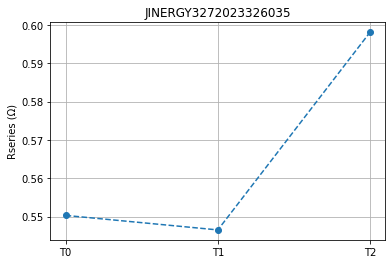

In [11]:
'''Creation: 2021.11.24
    Last update: 2021.11.25
A snippet for Pati 
'''

#3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv

irradiance = 1000
parameter = pv.GLOBAL['COL_NAMES'][5] # 1: Pmax, 2:Fill Factor, 3:Voc, 4:Rseries,
                                      # 5: Rshunt, 6: Vpm, 7: Ipm, 8: Isc_corr, 9: Fill Factor_corr
df_meta = pv.build_metadata_df_from_db(data_folder)
module_type = df_meta.loc[df_meta.index[0] ,'module_type']
dg = df_meta.query('irradiance==@irradiance')[[parameter,'treatment']]
_ = plt.plot(dg['treatment'],  dg[parameter],'--o')
_ = plt.ylabel(f'{parameter} ({pv.GLOBAL["PARAM_UNIT_DIC"][parameter]})')
_ = plt.title(module_type)
plt.grid()

In [ ]:
'''Creation: 2021.11.24
    Last update: 2021.11.25
Snippet using dataframe multi indexing 
'''

df_meta = pv.build_metadata_df_from_db(data_folder)
multi = df_meta.set_index(['module_type','irradiance', ])
g = multi.loc[('SERAPHIM-EM7621190702200646', 1000),:]
_ = plt.plot(g['treatment'],g['Fill Factor_corr'],'--o' )

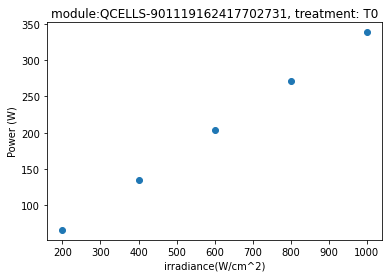

In [12]:
#3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv

df_meta = pv.build_metadata_df_from_db(data_folder)
g = df_meta.pivot(values= ['Pmax','irradiance'],index=['module_type','treatment' ],
              columns=['irradiance',]) 
x = g.loc[g.index[0][0],g.index[0][1]] ['irradiance'].to_numpy()
y = g.loc[g.index[0][0],g.index[0][1]] ['Pmax'].to_numpy()
_ = plt.scatter(x,y)
_ = plt.title(f'module:{g.index[0][0]}, treatment: {g.index[0][1]}')
_  = plt.xlabel('irradiance(W/cm^2)')
_ = plt.ylabel('Power (W)')

## Tools to improve data vizualization and exploration

In [14]:
'''Creation: 2021.11.24
    Last update: 2021.11.25
How improve dataframe visualization 
'''
df_meta = pv.build_metadata_df_from_db(data_folder)
df_meta.drop(['exp_id','Title','Fill Factor','Isc'],axis=1,inplace=True)
df_meta.style.bar(
    subset=["Pmax", "Fill Factor_corr"], color="#205ff2"
).format({'Pmax':'{:.2f}',
          'Voc':'{:.2f}',
          'Rseries':'{:.2f}',
          'Rshunt':'{:.2f}',
          'Vpm':'{:.2f}',
          'Ipm':'{:.2f}',
          'Isc_corr':'{:.2f}',
          'Fill Factor_corr':'{:.2f}',}).highlight_min(['Pmax','Fill Factor_corr'])

In [20]:
'''Creation: 2021.11.24
    Last update: 2021.11.25
How improve dataframe exploration
Before running this cell you must install in your activated venv danasgui using:
        pip install pandasgui
'''

from pandasgui import show
df_meta = pv.build_metadata_df_from_db(data_folder)
gui = show(df_meta)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [16]:
import pprint as pp
pp.pprint(pv.GLOBAL, depth=3, indent=4)

{   'COL_NAMES': [   'Title',
                     'Pmax',
                     'Fill Factor',
                     'Voc',
                     'Isc',
                     'Rseries',
                     'Rshunt',
                     'Vpm',
                     'Ipm'],
    'DATA_BASE_NAME': 'pv.db',
    'DATA_BASE_TABLE_EXP': 'exp_values',
    'DATA_BASE_TABLE_FILE': 'PV_descp',
    'DEFAULT_DIR': WindowsPath('C:/Users/franc'),
    'ENCODING': 'latin-1',
    'GEOMETRY_ITEMS_SELECTION': '500x580+50+50',
    'GEOMETRY_SELECT_DIR': '750x250',
    'IRRADIANCE_DEFAULT_LIST': [200, 200, 400, 600, 800, 1000, 2000, 4000],
    'PARAM_UNIT_DIC': {   'Fill Factor': '1',
                          'Fill Factor_corr': '1',
                          'Ipm': 'A',
                          'IrrCorr': 'W/m2',
                          'Isc': 'A',
                          'Isc_corr': 'A',
                          'Pmax': 'W',
                          'Rseries': 'Ω',
                          'Voc': 'V